## **Configure Kaggle & Download Dataset**

In [1]:
import os
import zipfile

# Move kaggle.json
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install -q kaggle

# Download and unzip UNSW-NB15 dataset
!kaggle datasets download -d dhoogla/unswnb15
with zipfile.ZipFile("unswnb15.zip", 'r') as zip_ref:
    zip_ref.extractall("unsw_nb15")


Dataset URL: https://www.kaggle.com/datasets/dhoogla/unswnb15
License(s): CC-BY-NC-SA-4.0
  0% 0.00/11.7M [00:00<?, ?B/s]
100% 11.7M/11.7M [00:00<00:00, 954MB/s]


# **Read & Concatenate Train/Test Data**

In [1]:
import pandas as pd

train_df = pd.read_parquet("/content/unsw_nb15/UNSW_NB15_training-set.parquet")
test_df = pd.read_parquet("/content/unsw_nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train_df, test_df], ignore_index=True)
df.head()


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,14158.942383,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8395.112305,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1572.271851,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2740.178955,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8561.499023,...,0,0,2,1,0,0,0,0,Normal,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float32 
 1   proto              257673 non-null  object  
 2   service            257673 non-null  category
 3   state              257673 non-null  object  
 4   spkts              257673 non-null  int16   
 5   dpkts              257673 non-null  int16   
 6   sbytes             257673 non-null  int32   
 7   dbytes             257673 non-null  int32   
 8   rate               257673 non-null  float32 
 9   sload              257673 non-null  float32 
 10  dload              257673 non-null  float32 
 11  sloss              257673 non-null  int16   
 12  dloss              257673 non-null  int16   
 13  sinpkt             257673 non-null  float32 
 14  dinpkt             257673 non-null  float32 
 15  sjit               257673 non-null

 # **Preprocess the Dataset**

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Make a copy
df_clean = df.copy()



# Encode object and categorical columns
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df_clean.drop(columns=['label'])
y = df_clean['label']


# **Exploratry data Analysis**

## **Visualize Label Distribution**

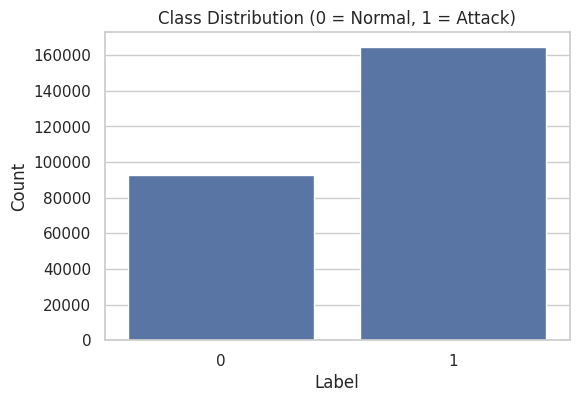

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution (0 = Normal, 1 = Attack)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# **Count plot to show protocol by attack Category**

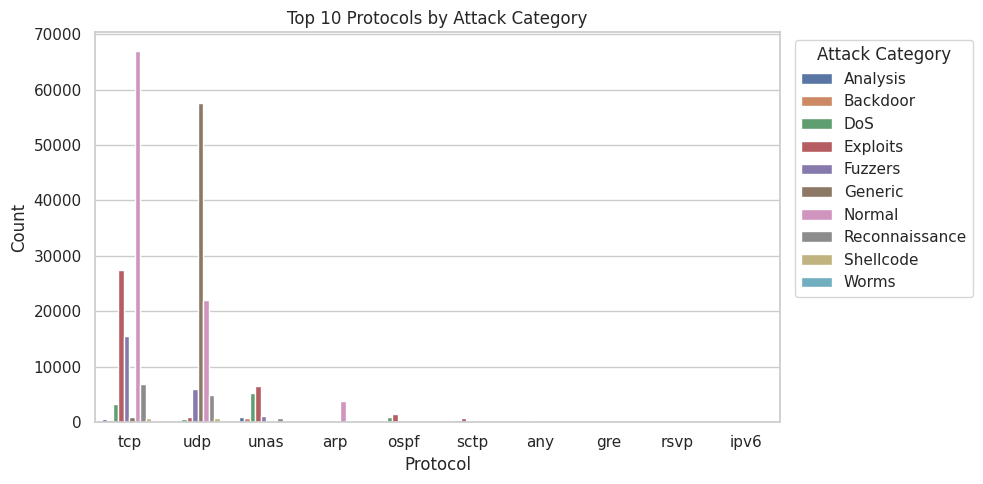

In [6]:

# Identify top 10 most common protocols
top_protos = df['proto'].value_counts().nlargest(10).index

# Filter dataset to top protocols only
filtered_df = df[df['proto'].isin(top_protos)]

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=filtered_df, x='proto', hue='attack_cat', order=top_protos)
plt.title("Top 10 Protocols by Attack Category")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Attack Category')
plt.tight_layout()
plt.show()

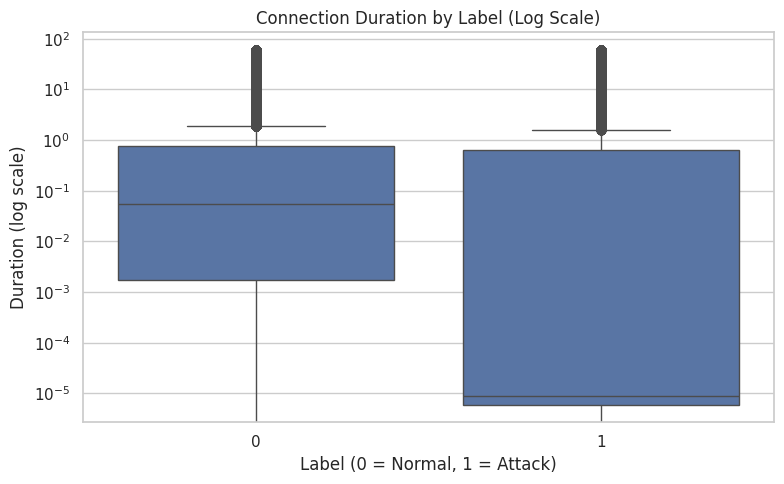

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='label', y='dur')
plt.yscale("log")
plt.title("Connection Duration by Label (Log Scale)")
plt.xlabel("Label (0 = Normal, 1 = Attack)")
plt.ylabel("Duration (log scale)")
plt.tight_layout()
plt.show()

# **Split the Data Set**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)


KeyboardInterrupt: 

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18613
           1       1.00      1.00      1.00     32922

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535



<Figure size 600x400 with 0 Axes>

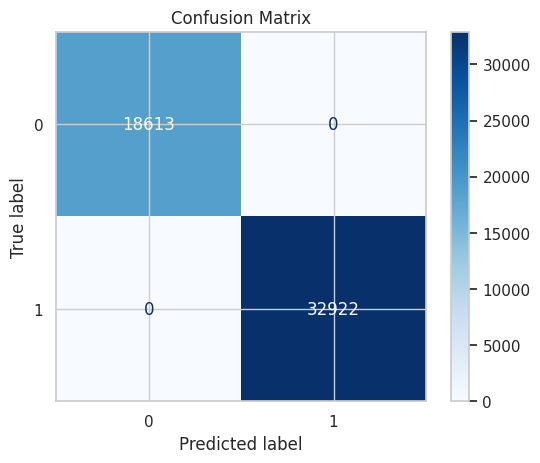

In [10]:
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# **Model Development**

## **Machine Learning Model**


--- Training and Evaluating Logistic Regression ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Time: 82.6983 seconds
Testing Time: 0.0179 seconds
Accuracy: 0.7989
Precision: 0.7855
Recall: 0.9426
F1-score: 0.8569

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.54      0.66     18613
           1       0.79      0.94      0.86     32922

    accuracy                           0.80     51535
   macro avg       0.81      0.74      0.76     51535
weighted avg       0.81      0.80      0.79     51535



<Figure size 600x400 with 0 Axes>

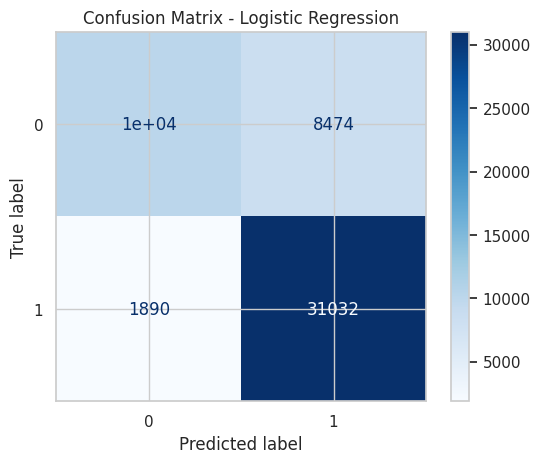

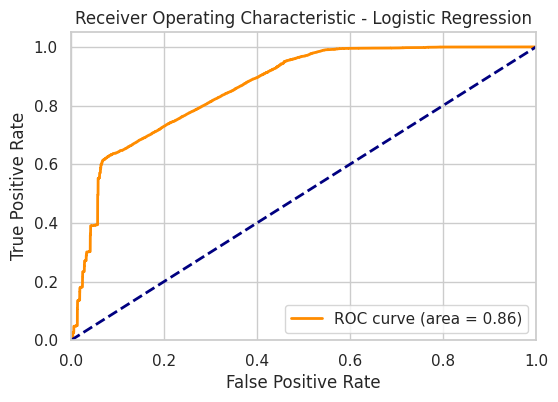


--- Training and Evaluating K-Nearest Neighbors ---
Training Time: 0.0852 seconds
Testing Time: 89.9507 seconds
Accuracy: 0.8570
Precision: 0.8720
Recall: 0.9096
F1-score: 0.8904

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.76      0.79     18613
           1       0.87      0.91      0.89     32922

    accuracy                           0.86     51535
   macro avg       0.85      0.84      0.84     51535
weighted avg       0.86      0.86      0.86     51535



<Figure size 600x400 with 0 Axes>

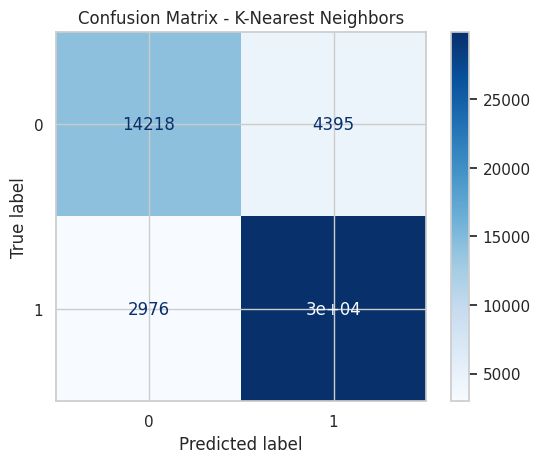

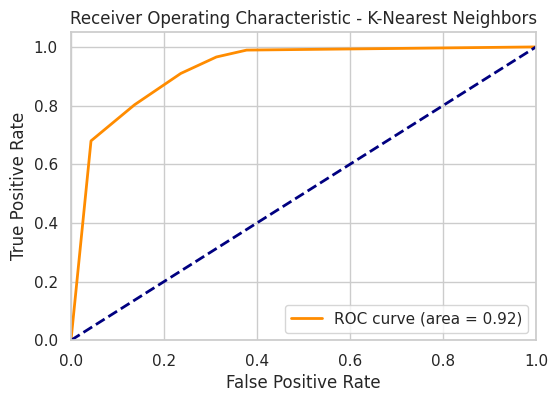


--- Training and Evaluating Gaussian Naive Bayes ---
Training Time: 0.1978 seconds
Testing Time: 0.0308 seconds
Accuracy: 0.7632
Precision: 0.7957
Recall: 0.8468
F1-score: 0.8205

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.62      0.65     18613
           1       0.80      0.85      0.82     32922

    accuracy                           0.76     51535
   macro avg       0.75      0.73      0.74     51535
weighted avg       0.76      0.76      0.76     51535



<Figure size 600x400 with 0 Axes>

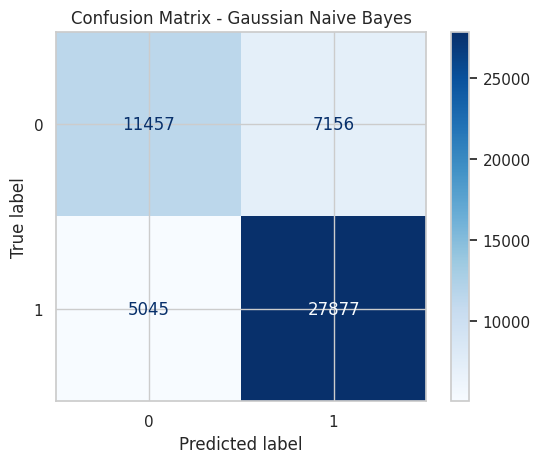

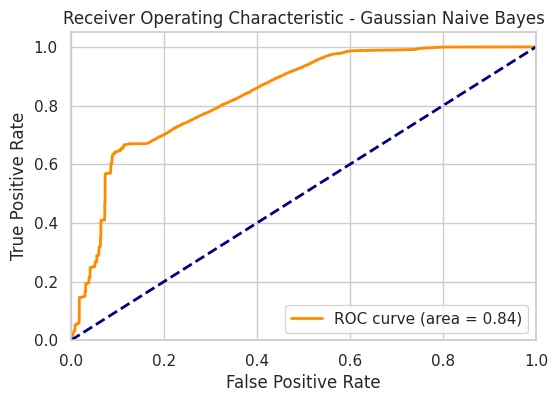


--- Training and Evaluating Neural Network ---
Training Time: 78.2580 seconds
Testing Time: 0.1182 seconds
Accuracy: 0.7772
Precision: 0.8173
Recall: 0.8389
F1-score: 0.8279

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.67      0.68     18613
           1       0.82      0.84      0.83     32922

    accuracy                           0.78     51535
   macro avg       0.76      0.75      0.76     51535
weighted avg       0.78      0.78      0.78     51535



<Figure size 600x400 with 0 Axes>

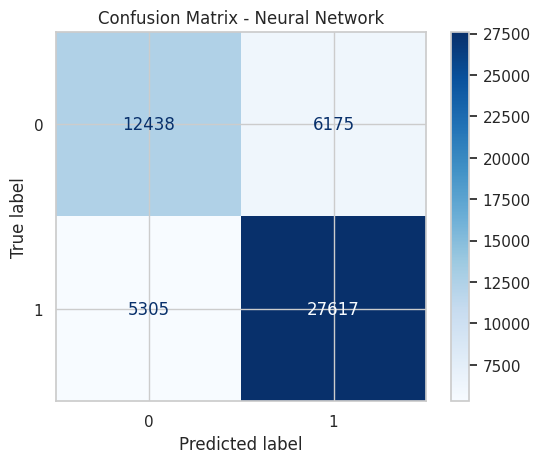

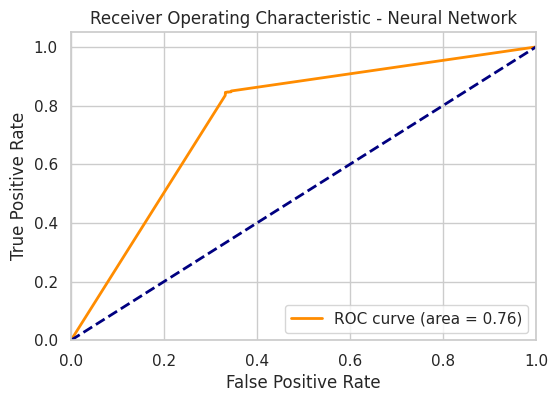


--- Model Performance Summary ---


,Training Time (s),Testing Time (s),Accuracy,Precision,Recall,F1-score,ROC AUC
Logistic Regression,82.698324,0.017883,0.798894,0.785501,0.942592,0.856906,0.861985
K-Nearest Neighbors,0.085220,89.950686,0.856971,0.872019,0.909605,0.890415,0.923445
Gaussian Naive Bayes,0.197771,0.030801,0.763248,0.795735,0.846759,0.820455,0.839086
Neural Network,78.257978,0.118231,0.777239,0.817264,0.838862,0.827922,0.755422


In [8]:

import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dictionary to store models and their names
models = {

    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),

    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    # Training time
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Testing time and prediction
    start_test_time = time.time()
    y_pred = model.predict(X_test)
    end_test_time = time.time()
    test_time = end_test_time - start_test_time

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results[name] = {
        "Training Time (s)": train_time,
        "Testing Time (s)": test_time,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Testing Time: {test_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Classification Report
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {name}')
        plt.legend(loc="lower right")
        plt.show()
        results[name]["ROC AUC"] = roc_auc
    else:
        print("ROC curve not available for this model.")

# Display a summary of results
print("\n--- Model Performance Summary ---")
results_df = pd.DataFrame(results).T
results_df

## **Deep learning Modle**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,049 (148.63 KB)

 Trainable params: 38,049 (148.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the LSTM Model ---
Epoch 1/50
2576/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8620 - f1_score: 0.7799 - loss: 0.2932 - precision: 0.8852 - recall: 0.9131

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.8621 - f1_score: 0.7799 - loss: 0.2931 - precision: 0.8853 - recall: 0.9131 - val_accuracy: 0.9957 - val_f1_score: 0.7782 - val_loss: 0.0472 - val_precision: 0.9969 - val_recall: 0.9963
Epoch 2/50
2576/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - f1_score: 0.7805 - loss: 0.0333 - precision: 0.9978 - recall: 0.9972

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9968 - f1_score: 0.7805 - loss: 0.0333 - precision: 0.9978 - recall: 0.9972 - val_accuracy: 0.9994 - val_f1_score: 0.7782 - val_loss: 0.0096 - val_precision: 0.9996 - val_recall: 0.9995
Epoch 3/50
2575/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - f1_score: 0.7830 - loss: 0.0094 - precision: 0.9991 - recall: 0.9995

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9991 - f1_score: 0.7830 - loss: 0.0094 - precision: 0.9991 - recall: 0.9995 - val_accuracy: 0.9995 - val_f1_score: 0.7782 - val_loss: 0.0042 - val_precision: 0.9996 - val_recall: 0.9997
Epoch 4/50
2569/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - f1_score: 0.7823 - loss: 0.0052 - precision: 0.9992 - recall: 0.9997

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9993 - f1_score: 0.7823 - loss: 0.0052 - precision: 0.9992 - recall: 0.9997 - val_accuracy: 0.9997 - val_f1_score: 0.7782 - val_loss: 0.0025 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 5/50
2573/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - f1_score: 0.7824 - loss: 0.0035 - precision: 0.9992 - recall: 0.9998

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9994 - f1_score: 0.7824 - loss: 0.0035 - precision: 0.9992 - recall: 0.9998 - val_accuracy: 0.9997 - val_f1_score: 0.7782 - val_loss: 0.0020 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 6/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9995 - f1_score: 0.7877 - loss: 0.0030 - precision: 0.9993 - recall: 0.9999 - val_accuracy: 0.9996 - val_f1_score: 0.7782 - val_loss: 0.0022 - val_precision: 0.9996 - val_recall: 0.9998
Epoch 7/50
2568/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - f1_score: 0.7888 - loss: 0.0024 - precision: 0.9994 - recall: 0.9999

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9996 - f1_score: 0.7888 - loss: 0.0024 - precision: 0.9994 - recall: 0.9999 - val_accuracy: 0.9997 - val_f1_score: 0.7782 - val_loss: 0.0018 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 8/50
2576/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - f1_score: 0.7900 - loss: 0.0022 - precision: 0.9994 - recall: 1.0000

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9996 - f1_score: 0.7900 - loss: 0.0022 - precision: 0.9994 - recall: 1.0000 - val_accuracy: 0.9997 - val_f1_score: 0.7782 - val_loss: 0.0018 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 9/50
2574/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - f1_score: 0.7969 - loss: 0.0027 - precision: 0.9993 - recall: 0.9999

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9995 - f1_score: 0.7969 - loss: 0.0027 - precision: 0.9993 - recall: 0.9999 - val_accuracy: 0.9997 - val_f1_score: 0.7872 - val_loss: 0.0018 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 10/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9997 - f1_score: 0.7972 - loss: 0.0020 - precision: 0.9995 - recall: 1.0000 - val_accuracy: 0.9997 - val_f1_score: 0.8143 - val_loss: 0.0018 - val_precision: 0.9996 - val_recall: 0.9999
Epoch 11/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9995 - f1_score: 0.8034 - loss: 0.0031 - precision: 0.9992 - recall: 0.9999 - val_accuracy: 0.9997 - val_f1_score: 0.7866 - val_loss: 0.0018 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 12/50
2574/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - f1_score: 0.7980 - loss: 0.0022 - precision: 0.9994 - recall: 1.0000

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9996 - f1_score: 0.7980 - loss: 0.0022 - precision: 0.9994 - recall: 1.0000 - val_accuracy: 0.9997 - val_f1_score: 0.8006 - val_loss: 0.0017 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 13/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9996 - f1_score: 0.8098 - loss: 0.0024 - precision: 0.9994 - recall: 1.0000 - val_accuracy: 0.9997 - val_f1_score: 0.8087 - val_loss: 0.0017 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 14/50
2573/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - f1_score: 0.8209 - loss: 0.0027 - precision: 0.9993 - recall: 1.0000

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9995 - f1_score: 0.8209 - loss: 0.0027 - precision: 0.9993 - recall: 1.0000 - val_accuracy: 0.9997 - val_f1_score: 0.8203 - val_loss: 0.0017 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 15/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9996 - f1_score: 0.8127 - loss: 0.0024 - precision: 0.9994 - recall: 0.9999 - val_accuracy: 0.9997 - val_f1_score: 0.8103 - val_loss: 0.0019 - val_precision: 0.9995 - val_recall: 1.0000
Epoch 16/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9996 - f1_score: 0.8202 - loss: 0.0023 - precision: 0.9994 - recall: 1.0000 - val_accuracy: 0.9997 - val_f1_score: 0.8232 - val_loss: 0.0017 - val_precision: 0.9996 - val_recall: 1.0000
Epoch 17/50
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9996 - f1_score: 0.8268 - loss: 0.0023 - precision: 0.9994 - recall: 1.0000 - val_accuracy: 0.9993 - val_f1_score: 0.8246 - val_loss: 0.0037 - val_precision: 0.9989 - val_rec

<Figure size 600x400 with 0 Axes>

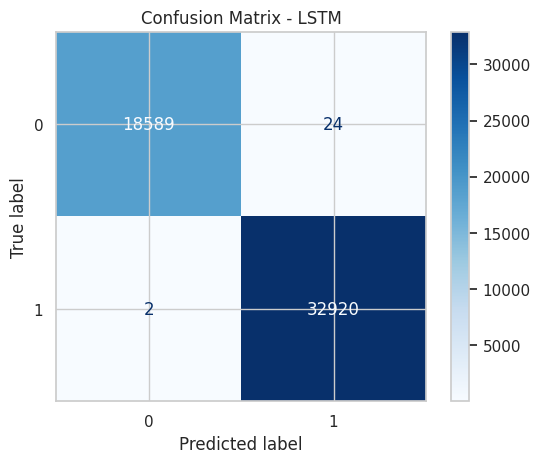


--- Plotting LSTM Training History ---


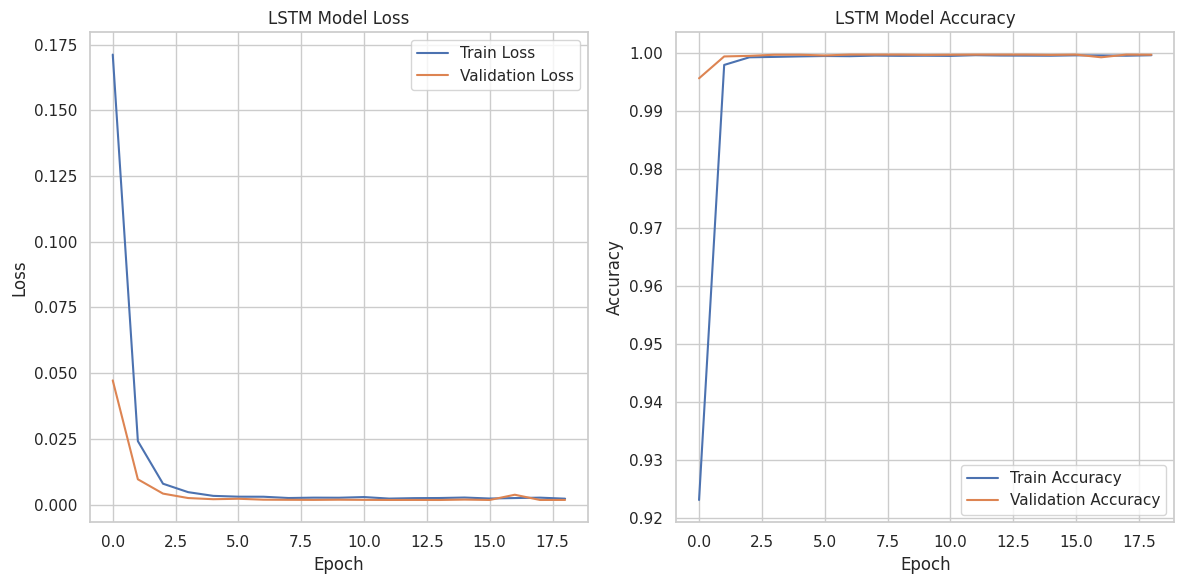

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


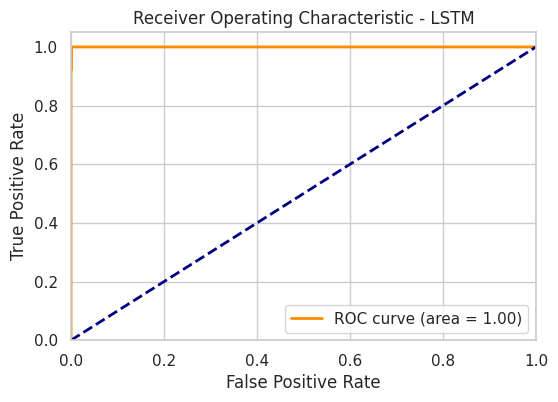


--- Updated Model Performance Summary ---


,Training Time (s),Testing Time (s),Accuracy,Precision,Recall,F1-score,ROC AUC
Logistic Regression,82.698324,0.017883,0.798894,0.785501,0.942592,0.856906,0.861985
K-Nearest Neighbors,0.085220,89.950686,0.856971,0.872019,0.909605,0.890415,0.923445
Gaussian Naive Bayes,0.197771,0.030801,0.763248,0.795735,0.846759,0.820455,0.839086
Neural Network,78.257978,0.118231,0.777239,0.817264,0.838862,0.827922,0.755422
LSTM,437.579412,5.202797,0.999496,0.999272,0.999939,0.821735,0.999897


In [9]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
import tensorflow as tf


# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
# For this dataset, each sample is a single timestep
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid')) # Binary classification

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

lstm_model.summary()

# Define callbacks for fine-tuning and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
print("\n--- Training the LSTM Model ---")
start_lstm_train_time = time.time()
history = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    validation_split=0.2, # Use part of training data for validation during training
    callbacks=[early_stopping, model_checkpoint]
)
end_lstm_train_time = time.time()
lstm_train_time = end_lstm_train_time - start_lstm_train_time
print(f"LSTM Training Time: {lstm_train_time:.4f} seconds")

# Evaluate the model on the test set
print("\n--- Evaluating the LSTM Model ---")
start_lstm_test_time = time.time()
loss, accuracy, precision, recall, f1 = lstm_model.evaluate(X_test_reshaped, y_test, verbose=0)
end_lstm_test_time = time.time()
lstm_test_time = end_lstm_test_time - start_lstm_test_time
print(f"LSTM Testing Time: {lstm_test_time:.4f} seconds")

print(f"LSTM Test Loss: {loss:.4f}")
print(f"LSTM Test Accuracy: {accuracy:.4f}")
print(f"LSTM Test Precision: {precision:.4f}")
print(f"LSTM Test Recall: {recall:.4f}")
print(f"LSTM Test F1 Score: {f1:.4f}")

# Classification Report (needs thresholding for binary prediction)
y_pred_prob = lstm_model.predict(X_test_reshaped)
y_pred_lstm = (y_pred_prob > 0.5).astype("int32") # Threshold at 0.5

print("\n📊 LSTM Classification Report:\n")
print(classification_report(y_test, y_pred_lstm, zero_division=0))

# Confusion Matrix for LSTM
plt.figure(figsize=(6, 4))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - LSTM")
plt.show()

# Plot training history
print("\n--- Plotting LSTM Training History ---")
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve and AUC for LSTM
y_proba_lstm = lstm_model.predict(X_test_reshaped).ravel()
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_proba_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LSTM')
plt.legend(loc="lower right")
plt.show()

# Add LSTM results to the summary
results['LSTM'] = {
    "Training Time (s)": lstm_train_time,
    "Testing Time (s)": lstm_test_time,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC AUC": roc_auc_lstm
}

# Display updated summary of results
print("\n--- Updated Model Performance Summary ---")
results_df_updated = pd.DataFrame(results).T
results_df_updated


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 1, 64)          │        19,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,833 (112.63 KB)

 Trainable params: 28,833 (112.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the GRU Model ---
Epoch 1/10
2574/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8748 - f1_score: 0.7813 - loss: 0.2790 - precision_2: 0.8998 - recall_2: 0.9140

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.8749 - f1_score: 0.7813 - loss: 0.2788 - precision_2: 0.8999 - recall_2: 0.9140 - val_accuracy: 0.9976 - val_f1_score: 0.7907 - val_loss: 0.0374 - val_precision_2: 0.9975 - val_recall_2: 0.9986
Epoch 2/10
2575/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - f1_score: 0.7948 - loss: 0.0254 - precision_2: 0.9983 - recall_2: 0.9930

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9944 - f1_score: 0.7948 - loss: 0.0254 - precision_2: 0.9983 - recall_2: 0.9930 - val_accuracy: 0.9993 - val_f1_score: 0.8068 - val_loss: 0.0036 - val_precision_2: 0.9996 - val_recall_2: 0.9994
Epoch 3/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - f1_score: 0.8041 - loss: 0.0057 - precision_2: 0.9993 - recall_2: 0.9992

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.9991 - f1_score: 0.8041 - loss: 0.0057 - precision_2: 0.9993 - recall_2: 0.9992 - val_accuracy: 0.9997 - val_f1_score: 0.8070 - val_loss: 0.0018 - val_precision_2: 0.9996 - val_recall_2: 0.9999
Epoch 4/10
2576/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - f1_score: 0.8063 - loss: 0.0031 - precision_2: 0.9993 - recall_2: 0.9998

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9995 - f1_score: 0.8063 - loss: 0.0031 - precision_2: 0.9993 - recall_2: 0.9998 - val_accuracy: 0.9996 - val_f1_score: 0.8031 - val_loss: 0.0011 - val_precision_2: 0.9994 - val_recall_2: 1.0000
Epoch 5/10
2571/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - f1_score: 0.8094 - loss: 0.0011 - precision_2: 0.9998 - recall_2: 0.9999

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9998 - f1_score: 0.8094 - loss: 0.0011 - precision_2: 0.9998 - recall_2: 0.9999 - val_accuracy: 1.0000 - val_f1_score: 0.8209 - val_loss: 1.0559e-04 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 6/10
2571/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - f1_score: 0.8198 - loss: 5.3031e-04 - precision_2: 0.9999 - recall_2: 0.9999

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9999 - f1_score: 0.8198 - loss: 5.3068e-04 - precision_2: 0.9999 - recall_2: 0.9999 - val_accuracy: 1.0000 - val_f1_score: 0.8246 - val_loss: 3.0373e-05 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 7/10
2574/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - f1_score: 0.8188 - loss: 8.7130e-04 - precision_2: 0.9998 - recall_2: 0.9998

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9998 - f1_score: 0.8188 - loss: 8.7069e-04 - precision_2: 0.9998 - recall_2: 0.9998 - val_accuracy: 1.0000 - val_f1_score: 0.8251 - val_loss: 1.5080e-05 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 8/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9998 - f1_score: 0.8282 - loss: 8.7739e-04 - precision_2: 0.9999 - recall_2: 0.9999 - val_accuracy: 1.0000 - val_f1_score: 0.8346 - val_loss: 1.7951e-05 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 9/10
2575/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - f1_score: 0.8268 - loss: 1.8091e-04 - precision_2: 1.0000 - recall_2: 1.0000

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 1.0000 - f1_score: 0.8268 - loss: 1.8089e-04 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 1.0000 - val_f1_score: 0.8293 - val_loss: 1.0156e-05 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 10/10
2573/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - f1_score: 0.8352 - loss: 1.7552e-04 - precision_2: 1.0000 - recall_2: 1.0000

2577/2577 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 1.0000 - f1_score: 0.8352 - loss: 1.7589e-04 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 1.0000 - val_f1_score: 0.8313 - val_loss: 7.1207e-06 - val_precision_2: 1.0000 - val_recall_2: 1.0000
GRU Training Time: 343.5720 seconds

--- Evaluating the GRU Model ---
GRU Testing Time: 4.9337 seconds
GRU Test Loss: 0.0000
GRU Test Accuracy: 1.0000
GRU Test Precision: 1.0000
GRU Test Recall: 1.0000
GRU Test F1 Score: 0.8329
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

📊 GRU Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18613
           1       1.00      1.00      1.00     32922

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535



<Figure size 600x400 with 0 Axes>

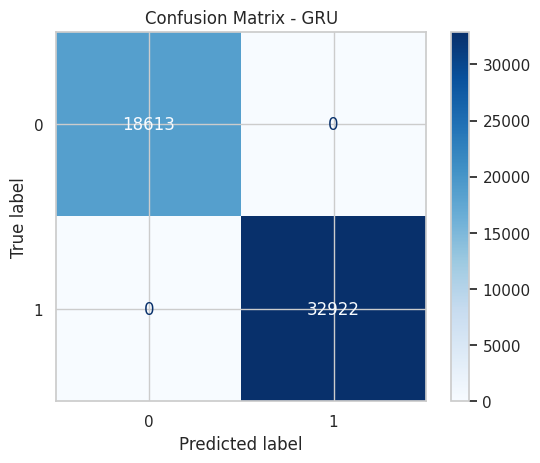


--- Plotting GRU Training History ---


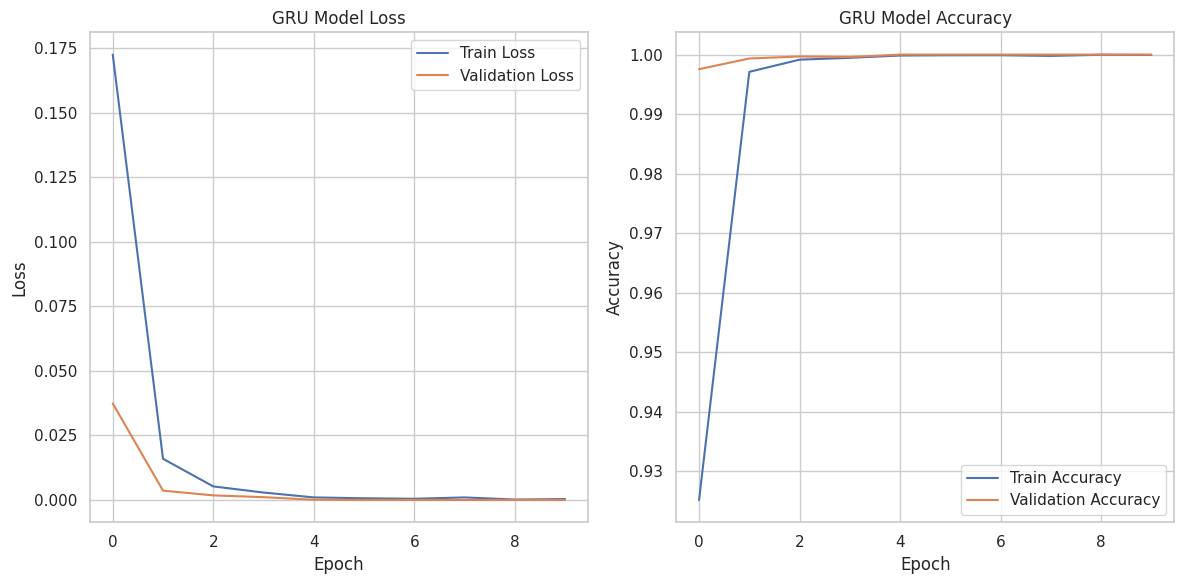

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


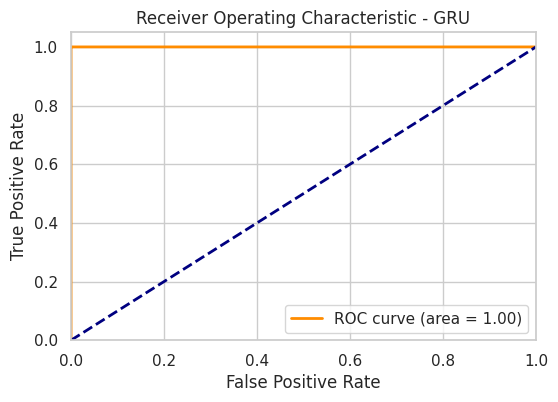


--- Updated Model Performance Summary ---


,Training Time (s),Testing Time (s),Accuracy,Precision,Recall,F1-score,ROC AUC
Logistic Regression,82.698324,0.017883,0.798894,0.785501,0.942592,0.856906,0.861985
K-Nearest Neighbors,0.085220,89.950686,0.856971,0.872019,0.909605,0.890415,0.923445
Gaussian Naive Bayes,0.197771,0.030801,0.763248,0.795735,0.846759,0.820455,0.839086
Neural Network,78.257978,0.118231,0.777239,0.817264,0.838862,0.827922,0.755422
LSTM,437.579412,5.202797,0.999496,0.999272,0.999939,0.821735,0.999897
GRU,343.572042,4.933675,1.000000,1.000000,1.000000,0.832920,1.000000


In [11]:


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, F1Score

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for GRU (samples, timesteps, features)
# For this dataset, each sample is a single timestep
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(units=64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=32, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1, activation='sigmoid')) # Binary classification

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

gru_model.summary()

# Define callbacks for fine-tuning and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_gru_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
print("\n--- Training the GRU Model ---")
start_gru_train_time = time.time()
history_gru = gru_model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2, # Use part of training data for validation during training
    callbacks=[early_stopping, model_checkpoint]
)
end_gru_train_time = time.time()
gru_train_time = end_gru_train_time - start_gru_train_time
print(f"GRU Training Time: {gru_train_time:.4f} seconds")

# Evaluate the model on the test set
print("\n--- Evaluating the GRU Model ---")
start_gru_test_time = time.time()
loss_gru, accuracy_gru, precision_gru, recall_gru, f1_gru = gru_model.evaluate(X_test_reshaped, y_test, verbose=0)
end_gru_test_time = time.time()
gru_test_time = end_gru_test_time - start_gru_test_time
print(f"GRU Testing Time: {gru_test_time:.4f} seconds")

print(f"GRU Test Loss: {loss_gru:.4f}")
print(f"GRU Test Accuracy: {accuracy_gru:.4f}")
print(f"GRU Test Precision: {precision_gru:.4f}")
print(f"GRU Test Recall: {recall_gru:.4f}")
print(f"GRU Test F1 Score: {f1_gru:.4f}")

# Classification Report (needs thresholding for binary prediction)
y_pred_prob_gru = gru_model.predict(X_test_reshaped)
y_pred_gru = (y_pred_prob_gru > 0.5).astype("int32") # Threshold at 0.5

print("\n📊 GRU Classification Report:\n")
print(classification_report(y_test, y_pred_gru, zero_division=0))

# Confusion Matrix for GRU
plt.figure(figsize=(6, 4))
cm_gru = confusion_matrix(y_test, y_pred_gru)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=[0, 1])
disp_gru.plot(cmap='Blues')
plt.title("Confusion Matrix - GRU")
plt.show()

# Plot training history
print("\n--- Plotting GRU Training History ---")
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve and AUC for GRU
y_proba_gru = gru_model.predict(X_test_reshaped).ravel()
fpr_gru, tpr_gru, thresholds_gru = roc_curve(y_test, y_proba_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gru, tpr_gru, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gru)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - GRU')
plt.legend(loc="lower right")
plt.show()

# Add GRU results to the summary
results['GRU'] = {
    "Training Time (s)": gru_train_time,
    "Testing Time (s)": gru_test_time,
    "Accuracy": accuracy_gru,
    "Precision": precision_gru,
    "Recall": recall_gru,
    "F1-score": f1_gru,
    "ROC AUC": roc_auc_gru
}

# Display updated summary of results
print("\n--- Updated Model Performance Summary ---")
results_df_updated = pd.DataFrame(results).T
results_df_updated